In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data

subroutine.py

In [2]:
import csv
def return_HM_npy(csvfile_path):
    H=[]
    M=[]
    with open(csvfile_path, 'r') as f:
        reader=csv.reader(f)
        header=next(reader) #skip header
        for row in reader:
            H.append(float(row[0]))
            M.append(float(row[1]))
    return np.array(H), np.array(M)

def accept_middle(H, M, noise_std=0.1, f=None):
    noise=abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else: return False

def generate_data(noise_std=0.1, datasize=10000, Hrange=[0.0, 6.0], Mrange=[0.0, 2.0], f=None):
    Hp=[]
    Mp=[]
    Fp=[]
    Hn=[]
    Mn=[]
    Fn=[]
    while True:
        H=np.random.uniform(Hrange[0], Hrange[1])
        M=np.random.uniform(Mrange[0], Mrange[1])
        if accept_middle(H, M, noise_std, f) and len(Hp)<datasize:
            Hp.append([H])
            Mp.append([M])
            Fp.append([0])
        elif len(Hn)<datasize:
            Hn.append([H])
            Mn.append([M])
            Fn.append([1])
        if len(Hp)>=datasize and len(Hn)>=datasize:
            break
    return (np.array(Hp), np.array(Mp), np.array(Fp)), (np.array(Hn), np.array(Mn), np.array(Fn))

def plot_all(H, M, Positive_HM, Negative_HM, f):
    plt.xlabel('H')
    plt.ylabel('M')
    plt.plot(Negative_HM[0], Negative_HM[1], 'y.', label='negative')
    plt.plot(Positive_HM[0], Positive_HM[1], 'b.', label='positive')
    hs=np.linspace(np.min(H), np.max(H), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(H, M, 'ro', label='data')
    plt.legend(loc='upper right',bbox_to_anchor=(1.05, 0.5, 0.5, .100))
    plt.show()

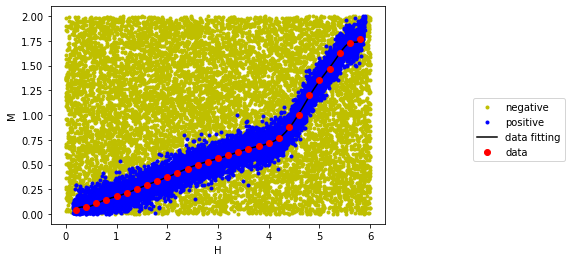

In [3]:
H,M=return_HM_npy('MHfile.csv')
f=np.poly1d(np.polyfit(H,M,deg=15))
Positive_HM, Negative_HM = generate_data(datasize=10000, f=f)
plot_all(H, M, Positive_HM, Negative_HM, f)

## Reformat training data
Make training data by class called 'Dataset'.

In [4]:
class phi_pi_dataset:
    def __init__(self, Positive_HM, Negative_HM, transform=None):
        self.phi=np.concatenate((Positive_HM[0], Negative_HM[0]), axis=0).astype(np.float32)
        self.pi=np.concatenate((Positive_HM[1], Negative_HM[1]), axis=0).astype(np.float32)
        self.ans = np.concatenate((Positive_HM[2], Negative_HM[2]), axis=0).astype(np.float32)
        self.transform=transform
    def __getitem__(self, index):
        phi=self.phi[index]
        pi=self.pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi=self.transform(phi)
            pi=self.transform(pi)
            ans = self.transform(ans)
        return phi, pi, ans
    def __len__(self):
        return len(self.phi)

In [5]:
train_d_loader = DataLoader(phi_pi_dataset(
                                Positive_HM=Positive_HM, 
                                Negative_HM=Negative_HM, 
                                transform=transforms.Compose([torch.from_numpy])), 
                                batch_size=100, shuffle=True)

# 2. Make a Neural network
neuralnet.py

In [6]:
import torch.nn as nn
import torch.nn.functional as F

def onestep(phi, pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*pi
    pi1 = phi*m2*del_eta + (1-del_eta*hh)*pi + del_eta*lamb*(phi1**3)
    return phi1, pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, pi, eta=None):
    ''' returning Pi'''
    F=pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

class Metricnet(nn.Module):
    def __init__(self, N_layer=None, eta_ini=None, eta_fin=None, del_eta=None, d=None):
        super(Metricnet, self).__init__()
        
        #trained parameters
        Hs=[]
        for layer_index in range (N_layer):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs=nn.ModuleList(Hs)
        self.lamb=nn.Linear(1, 1, bias=False)
        self.m2=nn.Linear(1, 1, bias=False)
        self.alpha=nn.Linear(1, 1, bias=False)
        self.beta=nn.Linear(1, 1, bias=False)
        
        #fixed parameters
        self.N_layer=N_layer
        self.eta_ini=eta_ini
        self.eta_fin=eta_fin
        self.del_eta=del_eta
        self.d=d
        self.one=Variable(torch.ones(1))
        
    def show_lamb(self):
        return self.lamb(self.one)
    def show_m2(self):
        return self.m2(self.one)
    def show_alpha(self):
        return self.alpha(self.one)
    def show_beta(self):
        return self.beta(self.one)
    
    def penalty(self, coef_list=None):
        penalty=0
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layer))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        pH=self.Hs[0](self.one)
        for i in range(1, self.N_layer):
            H = self.Hs[i]
            if H==self.Hs[9]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = penalty + c_reg2*(1/self.eta_fin - H(self.one))**2
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
    
    def forward(self, H=None, M=None):
        #initial layer
        D=torch.sqrt(torch.abs(1+4*self.m2(self.one)/(self.Hs[0](self.one)**2)))
        phi=self.alpha(self.one)*H + self.beta(self.one)*M
        pi=(d/2)*(D-1)*self.alpha(self.one)*H + (d/2)*(-D-1)*self.beta(self.one)*M
        for i in range (self.N_layer-1):
            phi, pi = onestep(phi, pi, hh=self.Hs[i](self.one), m2=self.m2(self.one), 
                              lamb=self.lamb(self.one), del_eta=self.del_eta)
        ff=f(phi, pi, eta=eta(self.N_layer, self.eta_ini, self.eta_fin, self.N_layer))
        final = t(ff, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss(self, phi=None, pi=None, answer=None, reg_coef_list=None):
        model_output=self.forward(H=phi, M=pi)
        loss=F.l1_loss(model_output, answer)**2
        loss=loss+self.penalty(coef_list=reg_coef_list)
        return loss

def init_weights(Model, d):
    for i in range (len(Model.Hs)):
        w=np.random.normal(2, 1)
        Model.Hs[i].weight.data.fill_(w)
    m2=np.random.normal(2, 1)
    lamb=np.random.normal(1, 1)
    alpha=np.random.uniform(-0.5, 0.5)
    beta=np.random.uniform(-0.5, 0.5)
    Model.m2.weight.data.fill_(m2)
    Model.lamb.weight.data.fill_(lamb)
    Model.alpha.weight.data.fill_(alpha)
    Model.beta.weight.data.fill_(beta)    

In [13]:
d=4
N_layer=10
eta_fin=1/N_layer
eta_ini=1
del_eta=(eta_fin-eta_ini)/N_layer
c_reg1=0.001
c_reg2=0.0001

#make network
Test=Metricnet(N_layer=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, del_eta=del_eta, d=d)
init_weights(Test, d)
optimizer = torch.optim.Adam(Test.parameters())
Test.train()
regularization_coeffs = [0] #(np.array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])*0.001).tolist()
for i in range(1, N_layer):
    regularization_coeffs.append(c_reg1*eta(i, eta_ini, eta_fin, N_layer)**4)
    
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layer)]
print("H: ", np.array(a))
print ("m2: {}, lambda: {}, alpha: {}, beta: {}".format(Test.show_m2().data.numpy()[0], Test.show_lamb().data.numpy()[0], Test.show_alpha().data.numpy()[0], Test.show_beta().data.numpy()[0]))

H:  [3.9119377 3.0126238 2.1303768 2.2066383 3.0600364 0.99154   1.205353
 1.7434447 1.7638501 1.68834  ]
m2: 3.065499782562256, lambda: 2.155226945877075, alpha: -0.03134637698531151, beta: -0.3849790096282959


# 3. Train NN

In [14]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(H=phis, M=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(H=phis, M=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('M', fontsize=12)
    al.set_ylabel('H', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='Positive')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layer,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

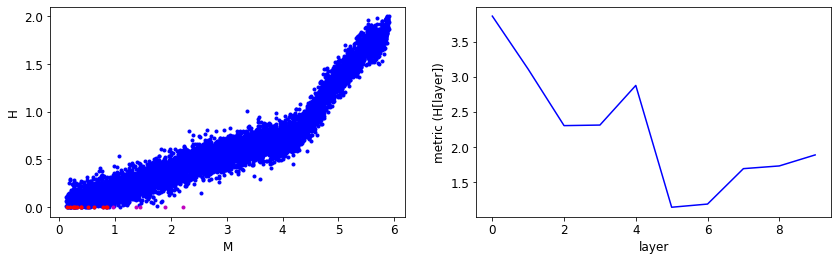

training epoch: 0,   loss: 0.26060906052589417
m2: 3.0461277961730957, lambda: 2.186321258544922, alpha: -0.043504904955625534, beta: -0.35157108306884766
[3.86156774 3.10683942 2.30408478 2.31206465 2.87586474 1.14318514
 1.18836153 1.69214416 1.73066068 1.88736212]


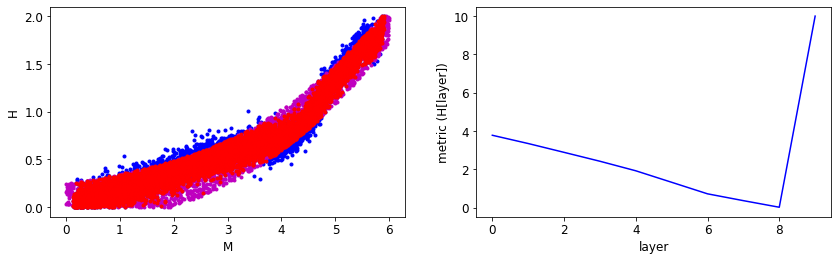

training epoch: 100,   loss: 0.012403883039951324
m2: 2.445500373840332, lambda: 2.208702564239502, alpha: -0.1155128926038742, beta: 0.012434049509465694
[3.77762938 3.34614611 2.8854866  2.42077327 1.92246139 1.32209361
 0.71926135 0.36298922 0.01879042 9.99999714]


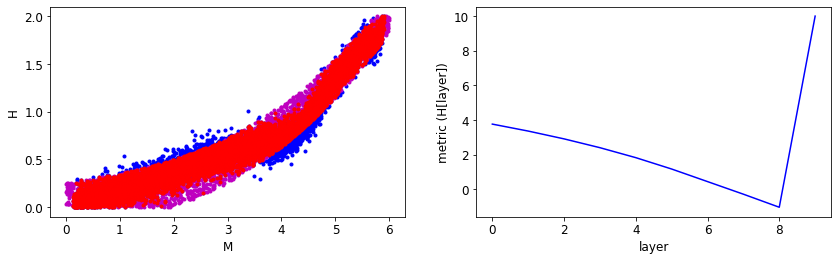

training epoch: 200,   loss: 0.01275379303842783
m2: 2.242670774459839, lambda: 2.0397067070007324, alpha: -0.12827354669570923, beta: 0.015020199120044708
[ 3.76792717  3.36647105  2.9155612   2.40730381  1.83197653  1.17578626
  0.45008636 -0.27670783 -1.02960145 10.        ]


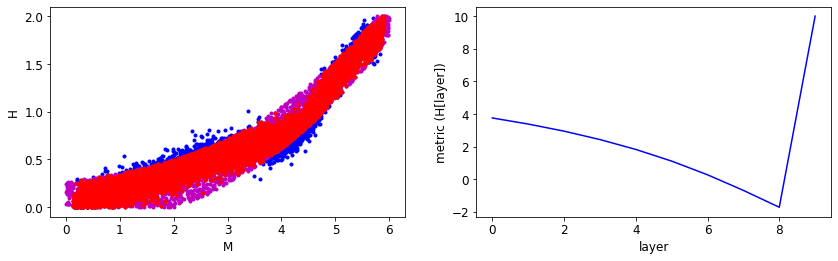

training epoch: 300,   loss: 0.012242544442415237
m2: 2.1559977531433105, lambda: 1.8585573434829712, alpha: -0.13550706207752228, beta: 0.016609100624918938
[ 3.75376248  3.38166809  2.94532537  2.43121552  1.8245424   1.10838389
  0.26959091 -0.68756628 -1.72033441 10.        ]


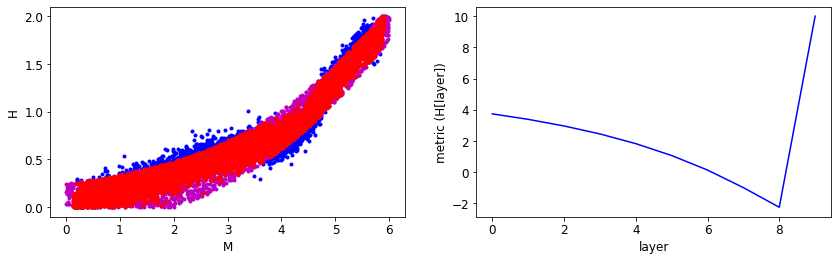

training epoch: 400,   loss: 0.012513387016952038
m2: 2.108051300048828, lambda: 1.6814361810684204, alpha: -0.14636929333209991, beta: 0.01905839517712593
[ 3.73942494  3.38822103  2.96472764  2.45383954  1.83223724  1.07175934
  0.14081044 -0.98466265 -2.2411077  10.        ]


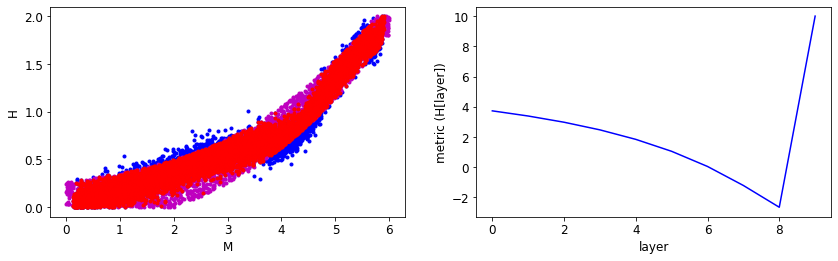

training epoch: 500,   loss: 0.012363835237920284
m2: 2.0887880325317383, lambda: 1.5030449628829956, alpha: -0.15561285614967346, beta: 0.019802536815404892
[ 3.72827482  3.38657427  2.97498894  2.46962953  1.84061897  1.04903221
  0.04633231 -1.21257007 -2.65292358 10.        ]


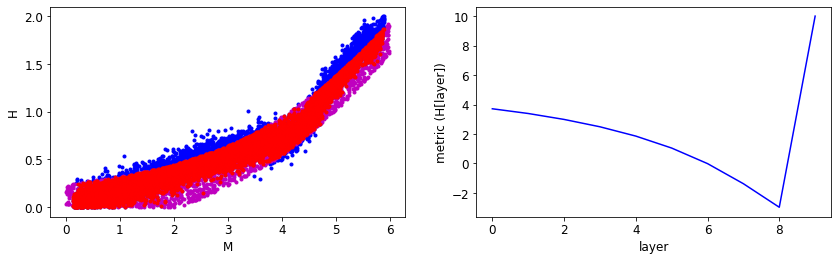

training epoch: 600,   loss: 0.012782572768628597
m2: 2.0853354930877686, lambda: 1.3267649412155151, alpha: -0.16343580186367035, beta: 0.022785620763897896
[ 3.71070719  3.39055109  2.98781013  2.48850894  1.85680139  1.04464078
 -0.01127361 -1.3758812  -2.97305441 10.        ]


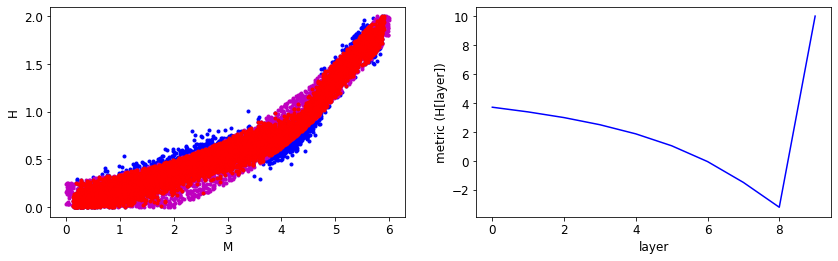

training epoch: 700,   loss: 0.012412894517183304
m2: 2.0995535850524902, lambda: 1.1574950218200684, alpha: -0.1738903969526291, beta: 0.021608002483844757
[ 3.70746326  3.38302183  2.99061751  2.49802256  1.86741459  1.04438329
 -0.04635787 -1.48694623 -3.20118213 10.        ]


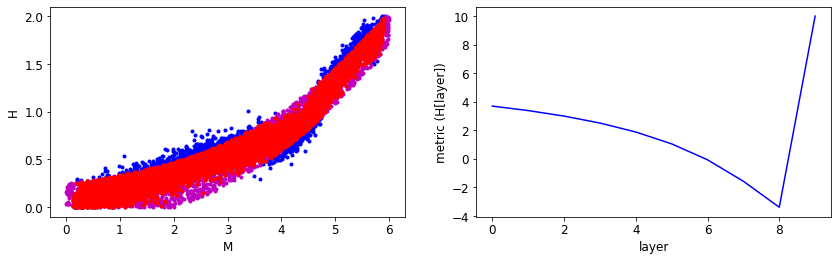

training epoch: 800,   loss: 0.012969860807061195
m2: 2.10160756111145, lambda: 0.9975077509880066, alpha: -0.18418173491954803, beta: 0.023340752348303795
[ 3.69640398  3.38173056  2.9953928   2.50882196  1.88028133  1.04979646
 -0.06773169 -1.57050478 -3.39042449 10.        ]


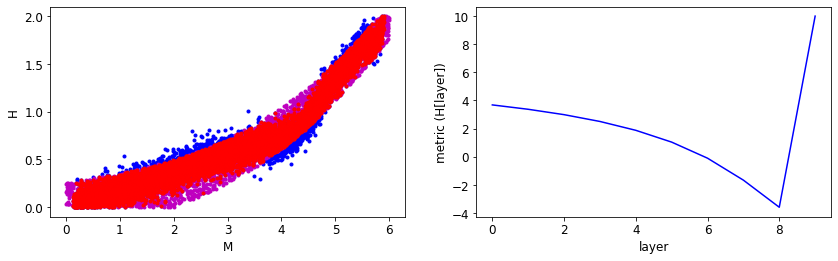

training epoch: 900,   loss: 0.012443981133401394
m2: 2.080620050430298, lambda: 0.8436416387557983, alpha: -0.1957312375307083, beta: 0.02336660586297512
[ 3.68569613  3.37521243  2.99290943  2.50897241  1.87961376  1.04033387
 -0.10286576 -1.66425335 -3.590832   10.        ]


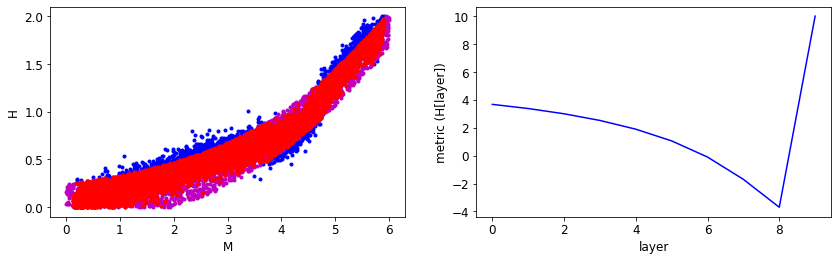

training epoch: 1000,   loss: 0.012916157022118568
m2: 2.073608636856079, lambda: 0.702693521976471, alpha: -0.2097824513912201, beta: 0.025106457993388176
[ 3.67348027  3.37504745  2.99958563  2.52103615  1.89488506  1.05378175
 -0.10306942 -1.70245516 -3.70118332 10.        ]


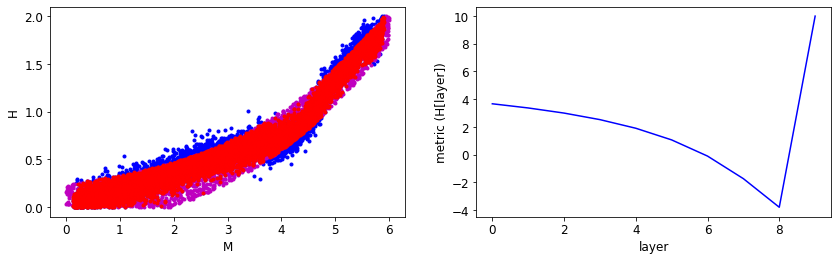

training epoch: 1100,   loss: 0.012302897870540619
m2: 2.0481810569763184, lambda: 0.5763078927993774, alpha: -0.2266290932893753, beta: 0.026218337938189507
[ 3.66677165  3.36568308  2.99566793  2.52264833  1.89999819  1.057531
 -0.11094752 -1.74303234 -3.80661726 10.        ]


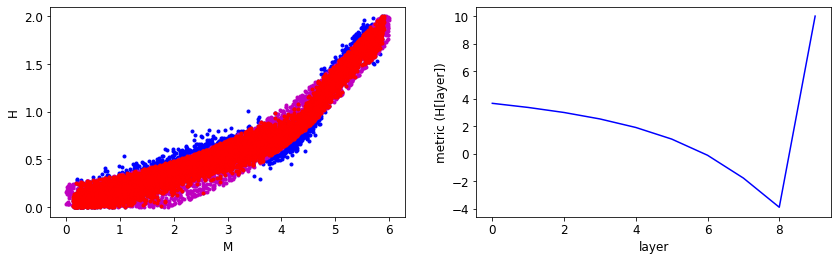

training epoch: 1200,   loss: 0.012363545596599579
m2: 2.0109598636627197, lambda: 0.45741772651672363, alpha: -0.24365493655204773, beta: 0.026227813214063644
[ 3.6586895   3.35880446  2.99205232  2.52272344  1.90293264  1.05990982
 -0.11758719 -1.77696002 -3.89787006 10.        ]


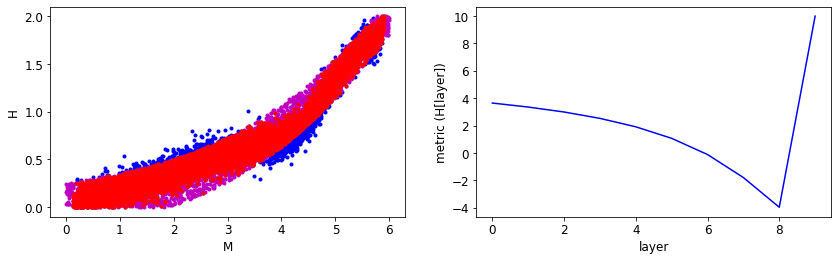

training epoch: 1300,   loss: 0.012442639097571373
m2: 1.9596879482269287, lambda: 0.35581663250923157, alpha: -0.26460570096969604, beta: 0.026092758402228355
[ 3.6466856   3.35419726  2.99241734  2.52728391  1.91059256  1.06789136
 -0.11622415 -1.79791367 -3.96792436 10.        ]


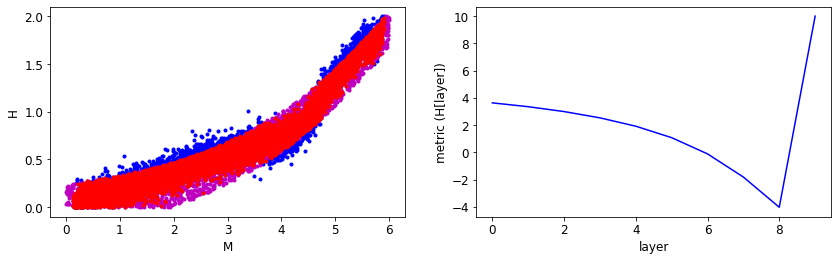

training epoch: 1400,   loss: 0.01293735858052969
m2: 1.8868647813796997, lambda: 0.27159035205841064, alpha: -0.28781089186668396, beta: 0.028471289202570915
[ 3.63157344  3.35045767  2.99288011  2.53199267  1.91844189  1.07615495
 -0.11380208 -1.81535351 -4.03099871 10.        ]


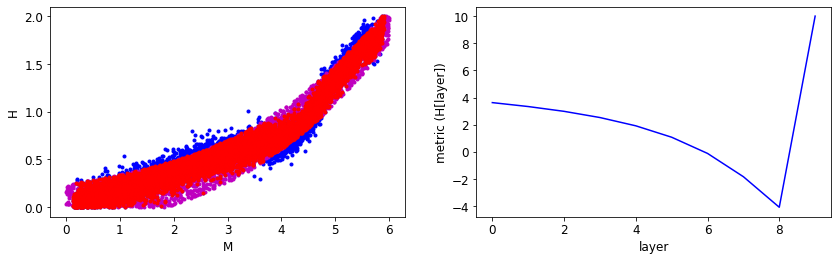

training epoch: 1500,   loss: 0.01261458732187748
m2: 1.8048545122146606, lambda: 0.20557714998722076, alpha: -0.3144700527191162, beta: 0.029160862788558006
[ 3.62656522  3.33710122  2.98375511  2.52695704  1.91688323  1.07621193
 -0.11706398 -1.83322704 -4.08310223 10.        ]


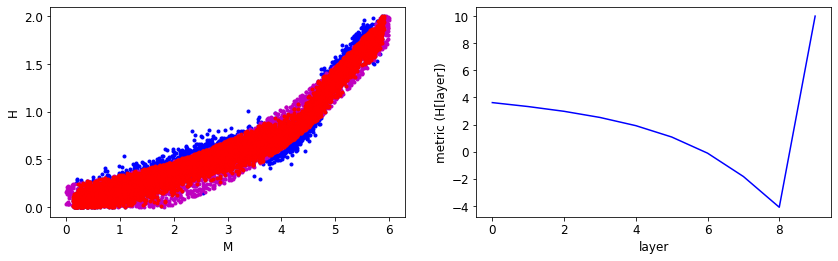

training epoch: 1600,   loss: 0.012135514058172703
m2: 1.7266324758529663, lambda: 0.15896479785442352, alpha: -0.3414663076400757, beta: 0.03035142458975315
[ 3.62127614  3.32937288  2.97920728  2.52668691  1.92144859  1.08505452
 -0.10684375 -1.82899737 -4.09627199 10.        ]


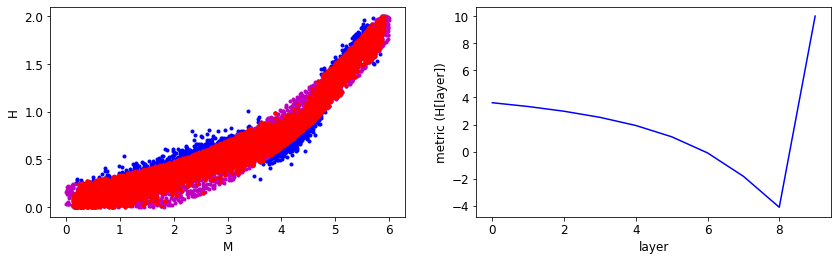

training epoch: 1700,   loss: 0.012065056711435318
m2: 1.6321662664413452, lambda: 0.12957078218460083, alpha: -0.3676966428756714, beta: 0.030863435938954353
[ 3.60861516  3.33010101  2.98139977  2.53175926  1.9304769   1.09795046
 -0.09227696 -1.81912363 -4.10273266 10.        ]


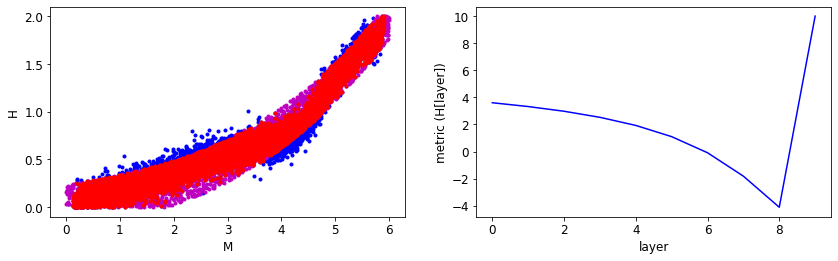

training epoch: 1800,   loss: 0.012089740484952927
m2: 1.543895959854126, lambda: 0.10730987042188644, alpha: -0.38862892985343933, beta: 0.031423818320035934
[ 3.60463262  3.32381201  2.9762938   2.5284543   1.93006194  1.10091424
 -0.08705175 -1.8161732  -4.11021471 10.        ]


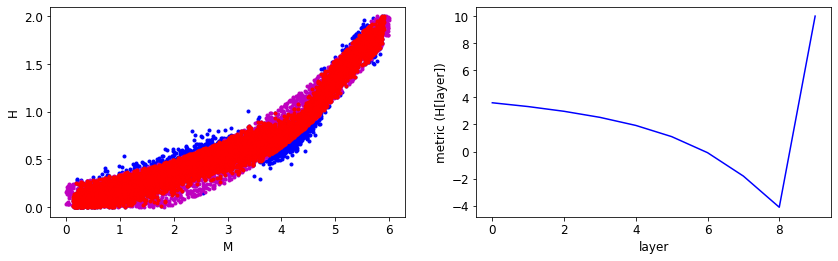

training epoch: 1900,   loss: 0.01244948711246252
m2: 1.4625083208084106, lambda: 0.09130694717168808, alpha: -0.40564975142478943, beta: 0.031458012759685516
[ 3.60125184  3.32056284  2.97159982  2.52454948  1.92820942  1.10191882
 -0.08355635 -1.81314349 -4.11313915 10.        ]


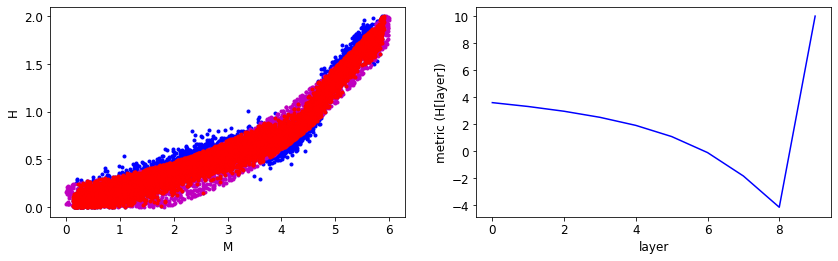

training epoch: 2000,   loss: 0.01182878389954567
m2: 1.3753730058670044, lambda: 0.08273522555828094, alpha: -0.41703736782073975, beta: 0.033787619322538376
[ 3.60088491  3.31475544  2.96323633  2.51433063  1.91741097  1.09141266
 -0.09405122 -1.82663846 -4.13743258 10.        ]


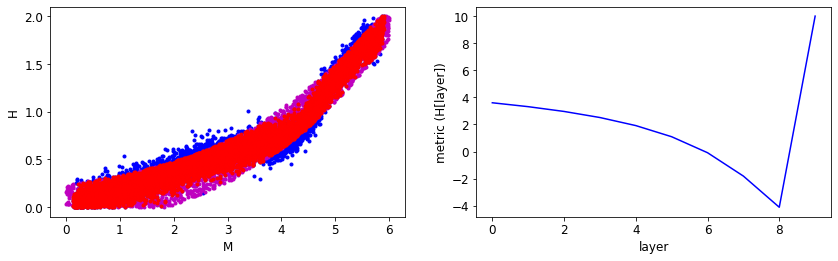

training epoch: 2100,   loss: 0.012007683515548706
m2: 1.328705906867981, lambda: 0.07766050845384598, alpha: -0.42980873584747314, beta: 0.03439173474907875
[ 3.60219741  3.31450033  2.96173167  2.51292181  1.91764176  1.0951072
 -0.08509511 -1.81094599 -4.11088133 10.        ]


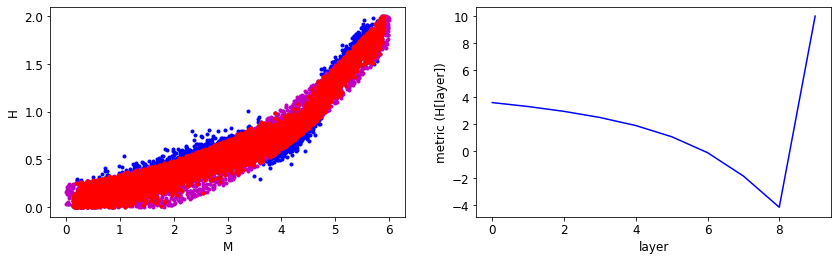

training epoch: 2200,   loss: 0.012811052612960339
m2: 1.2646112442016602, lambda: 0.06996942311525345, alpha: -0.430804044008255, beta: 0.03387485817074776
[ 3.60324931  3.31049609  2.95342064  2.5015254   1.90376925  1.07946312
 -0.10198335 -1.83013844 -4.13912678 10.        ]


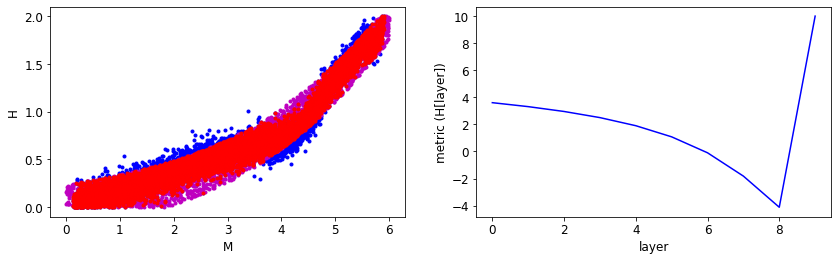

training epoch: 2300,   loss: 0.01209652703255415
m2: 1.2323956489562988, lambda: 0.07000469416379929, alpha: -0.4384934902191162, beta: 0.03468158096075058
[ 3.60379672  3.31148386  2.95383763  2.50056148  1.90231121  1.07898068
 -0.09963512 -1.82274532 -4.12292194 10.        ]


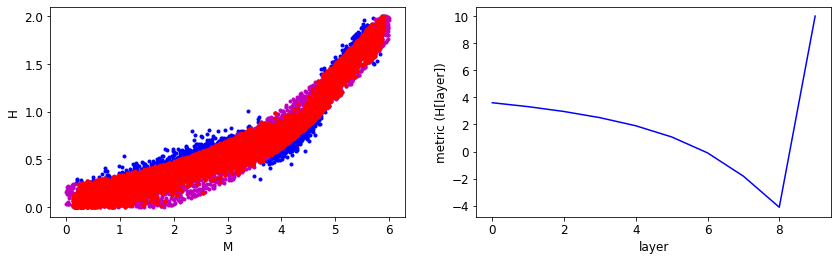

training epoch: 2400,   loss: 0.01189398393034935
m2: 1.2004691362380981, lambda: 0.06974001973867416, alpha: -0.4427223801612854, beta: 0.035212356597185135
[ 3.60195947  3.31353354  2.95501924  2.50049305  1.90118301  1.07748675
 -0.10013782 -1.82036889 -4.11561775 10.        ]


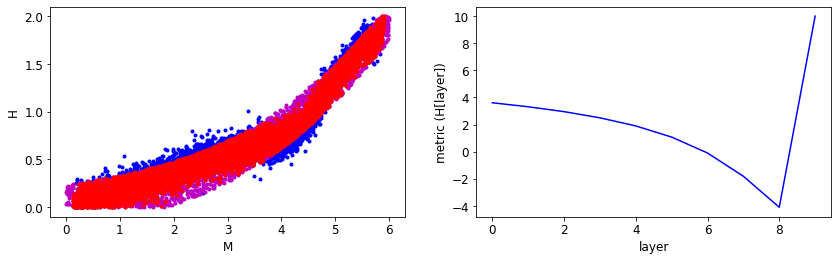

training epoch: 2500,   loss: 0.012202576734125614
m2: 1.1896142959594727, lambda: 0.06854727119207382, alpha: -0.44608429074287415, beta: 0.03599977493286133
[ 3.60670924  3.31183696  2.95196366  2.49691486  1.89733589  1.07404196
 -0.10159793 -1.81682742 -4.10160828 10.        ]


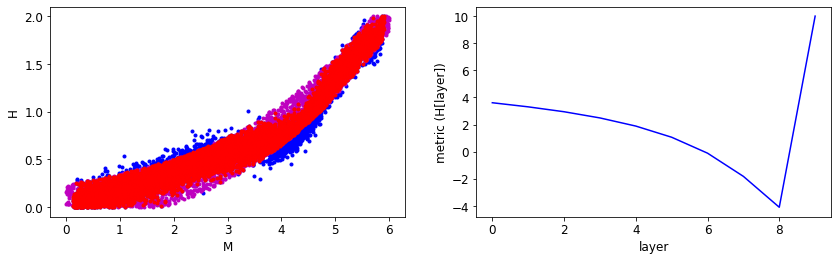

training epoch: 2600,   loss: 0.01185887772589922
m2: 1.184061050415039, lambda: 0.06764747202396393, alpha: -0.4481945335865021, beta: 0.03474503755569458
[ 3.61235762  3.30946541  2.94839287  2.49197006  1.89142179  1.06792676
 -0.1065935  -1.81804395 -4.09429312 10.        ]


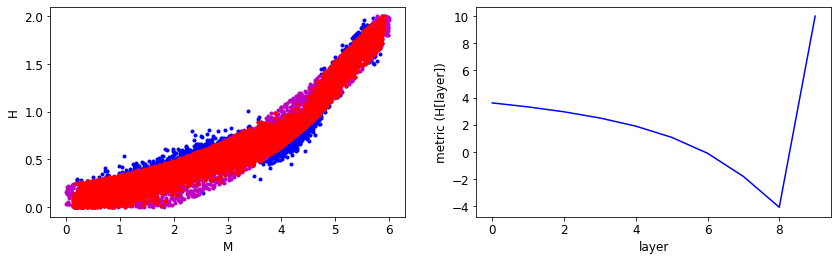

training epoch: 2700,   loss: 0.012044377624988556
m2: 1.1748511791229248, lambda: 0.06593120098114014, alpha: -0.447941392660141, beta: 0.03486721217632294
[ 3.60832787  3.31445909  2.95400786  2.49764585  1.89686441  1.07351208
 -0.0995944  -1.80697715 -4.0748539  10.        ]


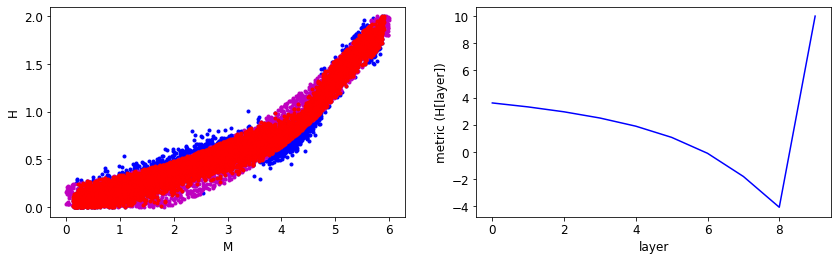

training epoch: 2800,   loss: 0.012460676021873951
m2: 1.1562992334365845, lambda: 0.0679938793182373, alpha: -0.44878020882606506, beta: 0.03548385575413704
[ 3.6073153   3.31502342  2.95441675  2.49777555  1.8965615   1.0727011
 -0.10046065 -1.80642319 -4.07137394 10.        ]


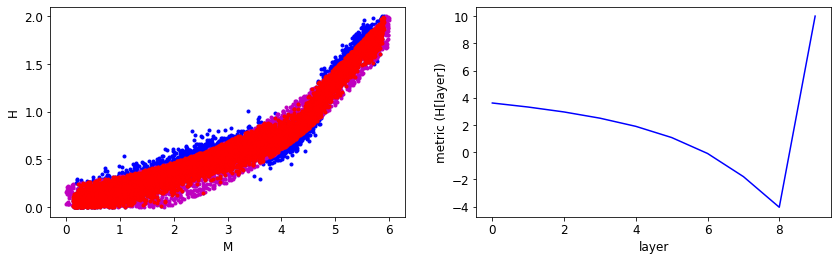

training epoch: 2900,   loss: 0.01181354746222496
m2: 1.1701302528381348, lambda: 0.06420458108186722, alpha: -0.44852128624916077, beta: 0.03636208921670914
[ 3.612082    3.31527758  2.95339537  2.49663544  1.89589846  1.07313311
 -0.09777738 -1.79865706 -4.05177069 10.        ]


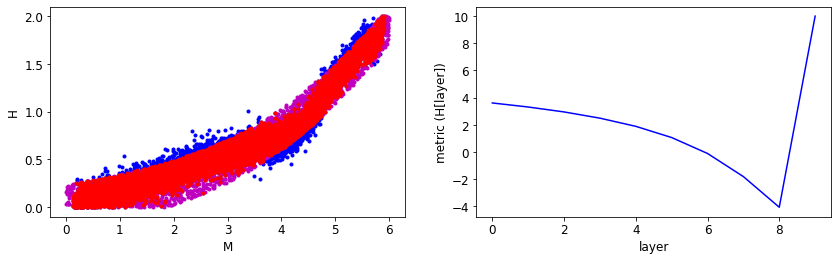

training epoch: 3000,   loss: 0.011698812246322632
m2: 1.154180645942688, lambda: 0.06289830803871155, alpha: -0.4455508887767792, beta: 0.03500848636031151
[ 3.61210227  3.31462765  2.95201898  2.49429083  1.89231539  1.06827903
 -0.10360595 -1.80474782 -4.05853033 10.        ]


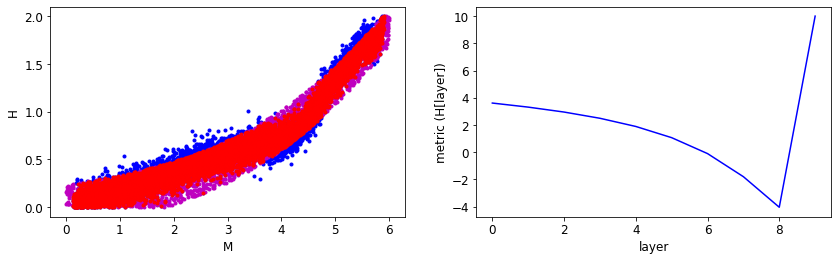

training epoch: 3100,   loss: 0.012084417045116425
m2: 1.1600170135498047, lambda: 0.06365979462862015, alpha: -0.44740116596221924, beta: 0.035930681973695755
[ 3.61403918  3.31511855  2.95316076  2.49618173  1.89491725  1.07190955
 -0.09800872 -1.79493594 -4.03894281 10.        ]


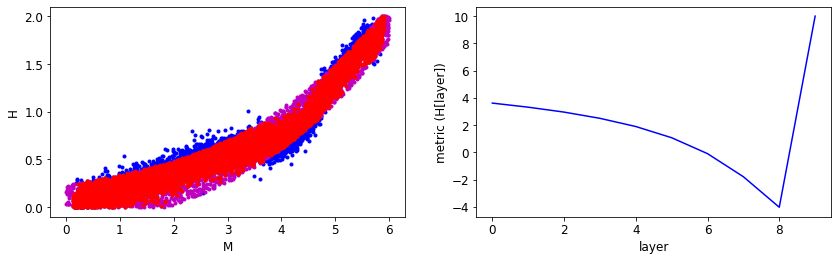

training epoch: 3200,   loss: 0.01197402086108923
m2: 1.1579705476760864, lambda: 0.06421396136283875, alpha: -0.4477783441543579, beta: 0.03560512512922287
[ 3.61475945  3.31499553  2.95401669  2.49692035  1.89561653  1.07286942
 -0.09621951 -1.79088771 -4.03001833 10.        ]


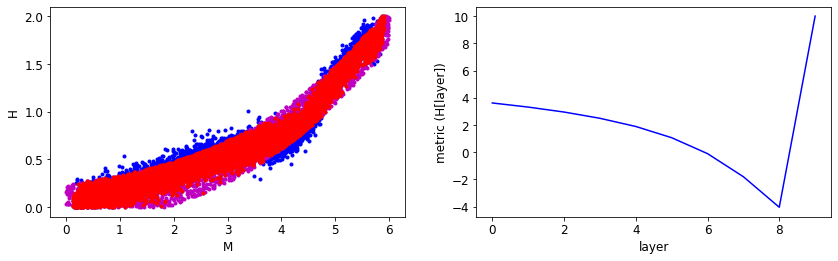

training epoch: 3300,   loss: 0.012126611545681953
m2: 1.1417748928070068, lambda: 0.06470339000225067, alpha: -0.44636160135269165, beta: 0.036188554018735886
[ 3.61642671  3.31438351  2.95008826  2.49121118  1.88850009  1.06420815
 -0.10664213 -1.80337417 -4.04652023 10.        ]


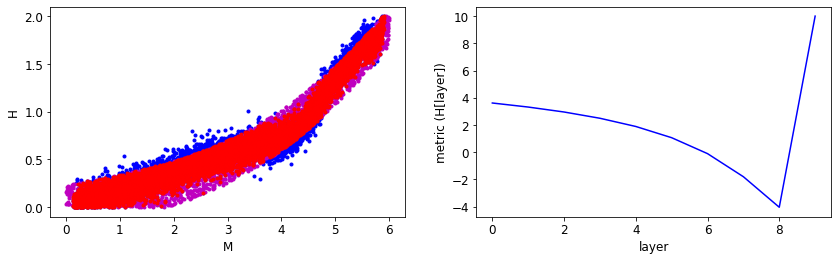

training epoch: 3400,   loss: 0.012107196263968945
m2: 1.1354782581329346, lambda: 0.06340059638023376, alpha: -0.4456411600112915, beta: 0.03574502468109131
[ 3.61396146  3.31614208  2.95233178  2.49261475  1.88890076  1.06375229
 -0.10772666 -1.80476677 -4.04765368 10.        ]


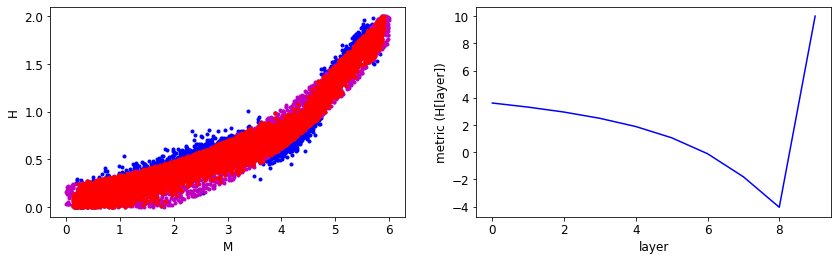

training epoch: 3500,   loss: 0.011809942312538624
m2: 1.1438809633255005, lambda: 0.06413949280977249, alpha: -0.44698765873908997, beta: 0.0357489250600338
[ 3.61662722  3.31518888  2.9513278   2.49191785  1.88835931  1.06340158
 -0.10738201 -1.80235803 -4.03970051 10.        ]


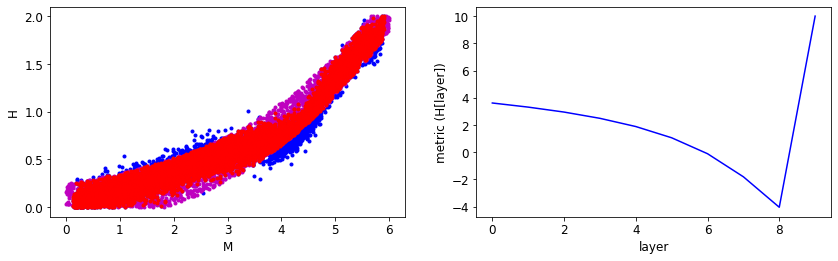

training epoch: 3600,   loss: 0.012269134633243084
m2: 1.1365163326263428, lambda: 0.06499966233968735, alpha: -0.44771164655685425, beta: 0.034068793058395386
[ 3.61707163  3.31416011  2.95030451  2.49085259  1.88704228  1.06157804
 -0.10976131 -1.80493021 -4.0420022  10.        ]


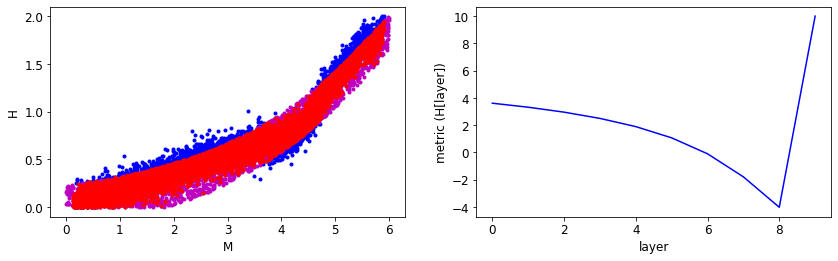

training epoch: 3700,   loss: 0.012313750572502613
m2: 1.146527886390686, lambda: 0.06421367824077606, alpha: -0.4475885331630707, beta: 0.03715876489877701
[ 3.61298394  3.31883001  2.95746207  2.49923801  1.89660752  1.07265675
 -0.09654038 -1.78796625 -4.01669931 10.        ]


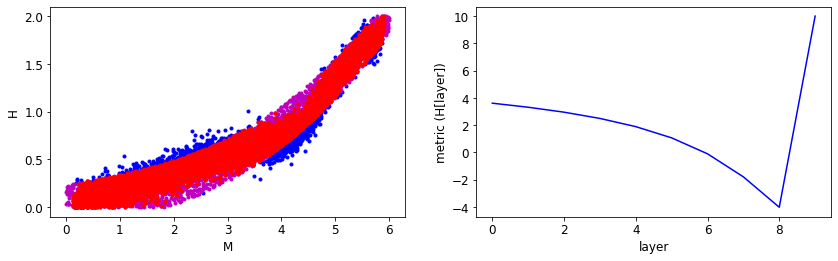

training epoch: 3800,   loss: 0.01175098679959774
m2: 1.1394888162612915, lambda: 0.06744133681058884, alpha: -0.44920670986175537, beta: 0.03544658049941063
[ 3.61485291  3.31779861  2.95517898  2.49707031  1.89474726  1.07103503
 -0.09786528 -1.78853226 -4.01592588 10.        ]


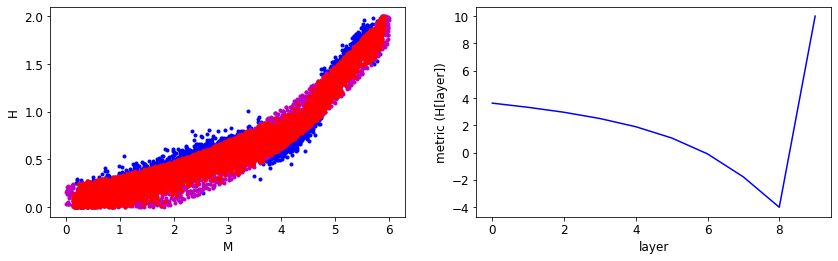

training epoch: 3900,   loss: 0.011902935802936554
m2: 1.1551995277404785, lambda: 0.06340283155441284, alpha: -0.4473557770252228, beta: 0.03586438298225403
[ 3.62060714  3.31432962  2.95165753  2.49351335  1.89142191  1.0683409
 -0.09942508 -1.78790426 -4.01031494 10.        ]


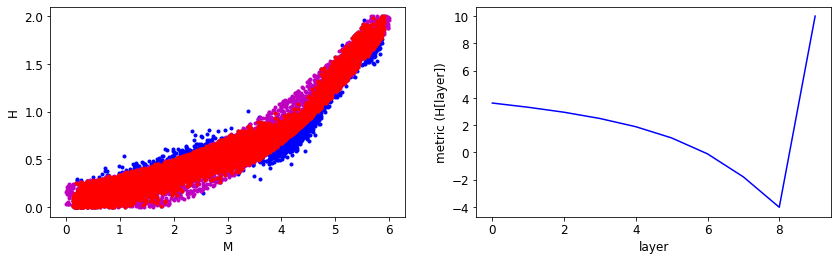

training epoch: 4000,   loss: 0.011939742602407932
m2: 1.141261100769043, lambda: 0.06703735142946243, alpha: -0.44911226630210876, beta: 0.03479277342557907
[ 3.62253928  3.31258202  2.94825006  2.48902392  1.88599515  1.06196618
 -0.10689402 -1.79694641 -4.02266693 10.        ]


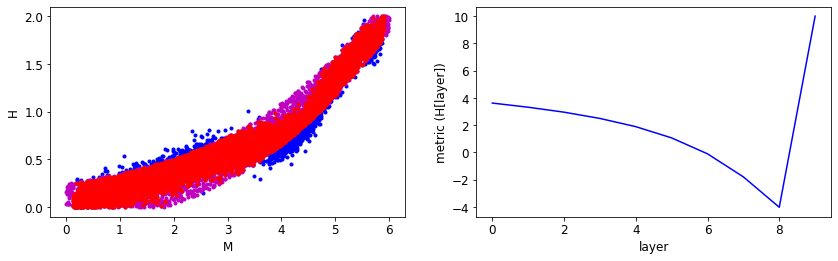

training epoch: 4100,   loss: 0.011765548028051853
m2: 1.1310745477676392, lambda: 0.06521888822317123, alpha: -0.44659775495529175, beta: 0.03418578580021858
[ 3.61917114  3.31450009  2.9504981   2.49110675  1.88748026  1.06273878
 -0.10682216 -1.79769671 -4.02567673 10.        ]


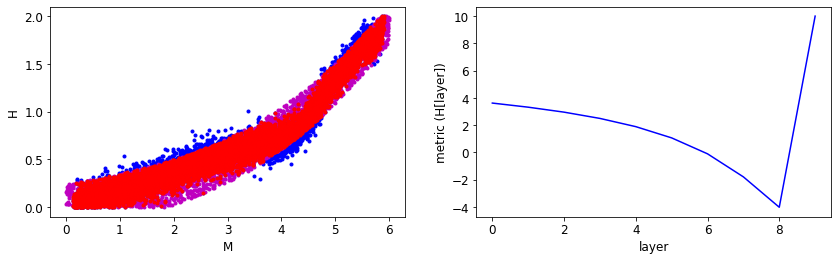

training epoch: 4200,   loss: 0.011757227592170238
m2: 1.1315205097198486, lambda: 0.06197495386004448, alpha: -0.44396790862083435, beta: 0.034693632274866104
[ 3.61794019  3.31593776  2.95139217  2.49149299  1.8874563   1.06225634
 -0.10780815 -1.79923356 -4.02805519 10.        ]


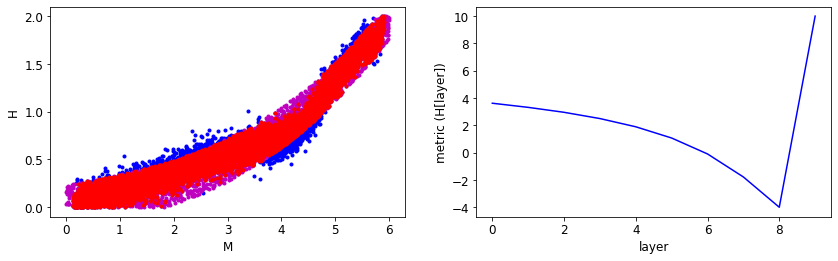

training epoch: 4300,   loss: 0.01202502753585577
m2: 1.1505573987960815, lambda: 0.06402959674596786, alpha: -0.4481075406074524, beta: 0.035212911665439606
[ 3.61967134  3.31672144  2.95471406  2.49638867  1.89402354  1.07103848
 -0.09581482 -1.78182876 -3.99871707 10.        ]


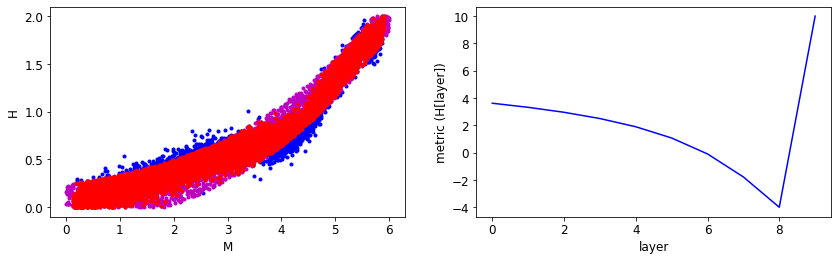

training epoch: 4400,   loss: 0.0120248356834054
m2: 1.1349202394485474, lambda: 0.0662766844034195, alpha: -0.44806331396102905, beta: 0.03490699455142021
[ 3.61808038  3.31741285  2.95503235  2.49675679  1.89435017  1.07109177
 -0.0961861  -1.78271592 -4.00143147 10.        ]


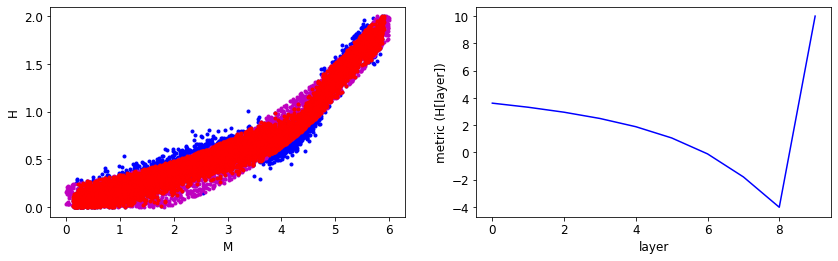

training epoch: 4500,   loss: 0.012251246720552444
m2: 1.1217997074127197, lambda: 0.06622901558876038, alpha: -0.4466218948364258, beta: 0.03562502935528755
[ 3.61715579  3.31804967  2.95374084  2.49423718  1.89094329  1.06664824
 -0.10211656 -1.79104424 -4.01509428 10.        ]


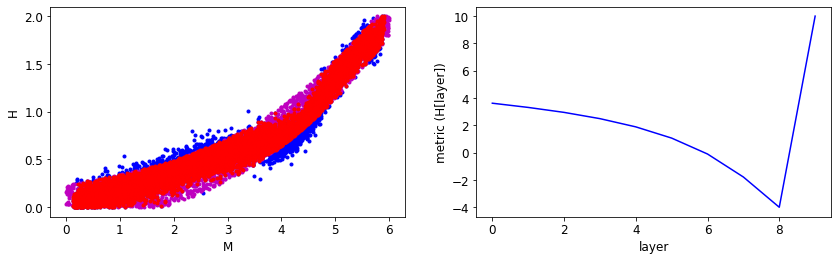

training epoch: 4600,   loss: 0.01206465344876051
m2: 1.1517828702926636, lambda: 0.06555742025375366, alpha: -0.44902196526527405, beta: 0.035444922745227814
[ 3.62397695  3.31528521  2.95237923  2.49401641  1.89197183  1.06963027
 -0.09606767 -1.77983117 -3.99242091 10.        ]


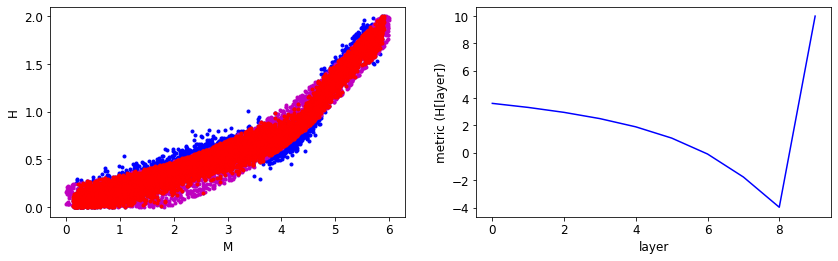

training epoch: 4700,   loss: 0.011585776694118977
m2: 1.1453678607940674, lambda: 0.06430613249540329, alpha: -0.44732117652893066, beta: 0.03524170443415642
[ 3.61703634  3.32127881  2.95963454  2.50208211  1.90055704  1.07862234
 -0.0865121  -1.76926267 -3.980546   10.        ]


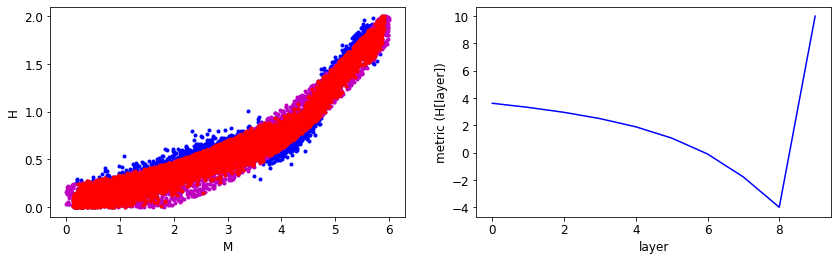

training epoch: 4800,   loss: 0.012016159482300282
m2: 1.1365599632263184, lambda: 0.06424710899591446, alpha: -0.445595920085907, beta: 0.03556016460061073
[ 3.61940742  3.31902313  2.9557662   2.49723196  1.89502811  1.07230544
 -0.09391223 -1.77827072 -3.99305844 10.        ]


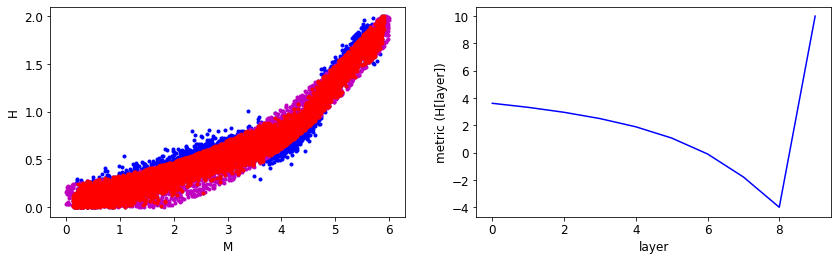

training epoch: 4900,   loss: 0.012309052981436253
m2: 1.1284452676773071, lambda: 0.06575316935777664, alpha: -0.44636547565460205, beta: 0.035772502422332764
[ 3.61672187  3.32147074  2.95820284  2.49928331  1.89664876  1.07367563
 -0.09271432 -1.77738941 -3.99316573 10.        ]


In [15]:
total_epoch=5000
show_epoch_each=100
for epoch in range (total_epoch):
    batches=iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_pi, b_ans) in batches:
        phi, pi, ans = Variable(b_phi), Variable(b_pi), Variable(b_ans)
        loss = Test.loss(phi=phi, pi=pi, answer=ans, reg_coef_list=regularization_coeffs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break
        
    if epoch % show_epoch_each == 0:
        nx, ny, px, py, Hs = plot_phase_and_metric(threshold=0.1, eta_or_layer='layer',
                                         positive_H_M_F=Positive_HM, negative_H_M_F=Negative_HM, Net=Test)
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("m2: {}, lambda: {}, alpha: {}, beta: {}".format(Test.show_m2().data.numpy()[0], Test.show_lamb().data.numpy()[0], Test.show_alpha().data.numpy()[0], Test.show_beta().data.numpy()[0]))
        print(np.array([v[0] for v in Hs]))